In [13]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from scipy.optimize import fsolve
import casadi as ca
import matplotlib.pyplot as plt


In [14]:
np.random.seed(42)
alpha0 = np.random.uniform(0.2, 0.8)
A1 = (2.6)*(10**-3)
Lc = 2
kv = 0.38
P1 = 4.5
P_out = 5
C = 479

def fun(variables, A1, Lc, kv, P1, P_out, C) :
    (x,y) = variables
    eqn_1 = (A1/Lc)* ((1.5 * P1) - y)
    eqn_2 = (C**2)/2 * (x - alpha0 * kv * np.sqrt(y - P_out))
    return [eqn_1, eqn_2]


result = fsolve(fun, (0, 10), args = (A1, Lc, kv, P1, P_out, C)) 

init_m = result[0]
init_p = result[1]
interval = [np.linspace(i * 500, (i + 1) * 500, 500) for i in range(10)]
x = ca.MX.sym('x', 2)
alpha = ca.MX.sym('alpha', 1)
massFlowrate = []
PlenumPressure = []
alpha_values = [np.full(500, alpha0)]
RNN_train = []
RNN_test = []

for i in range(0,10):  
    if i ==0:
        alpha1 = alpha0
    else:
        alpha1 = np.random.uniform(0.2, 0.8)
        alpha_values.append(np.full(500, alpha1))
    
    rhs = ca.vertcat((A1/Lc)*((1.5 * P1) - x[1]), (C**2)/2 * (x[0] - alpha * kv * np.sqrt(x[1] - P_out)))
    ode = {'x' : x, 'ode' : rhs, 'p' : alpha }

    F = ca.integrator('F','idas', ode, interval[i][0], interval[i])
    
    sol = F(x0 = [init_m, init_p], p = alpha1)

    xf_values = np.array(sol["xf"])

    aux1, aux2 = xf_values
    massFlowrate.append(aux1)
    PlenumPressure.append(aux2)
    init_m = aux1[-1]
    init_p = aux2[-1]

    if i < 5:
        RNN_train.append([aux1, aux2, np.full(500,alpha1)])
    else:
        RNN_test.append([aux1, aux2, np.full(500,alpha1)])


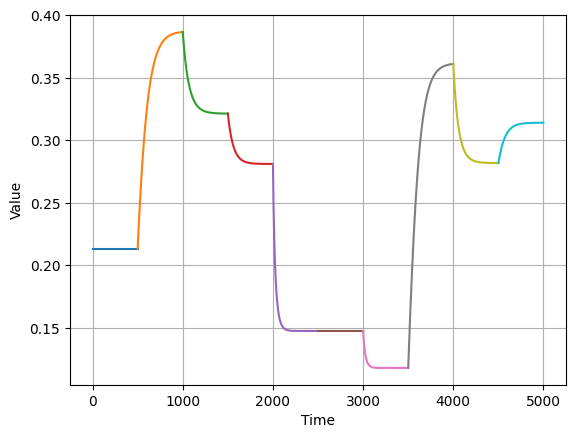

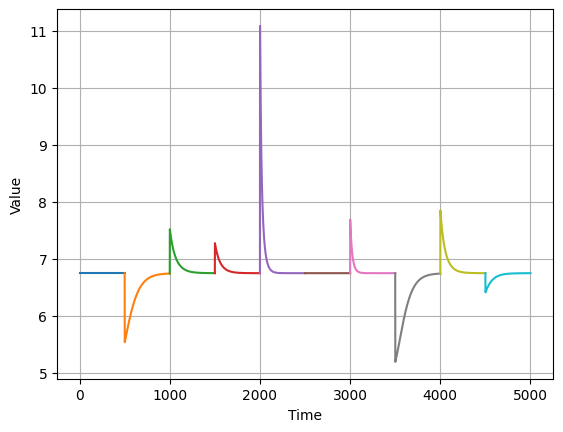

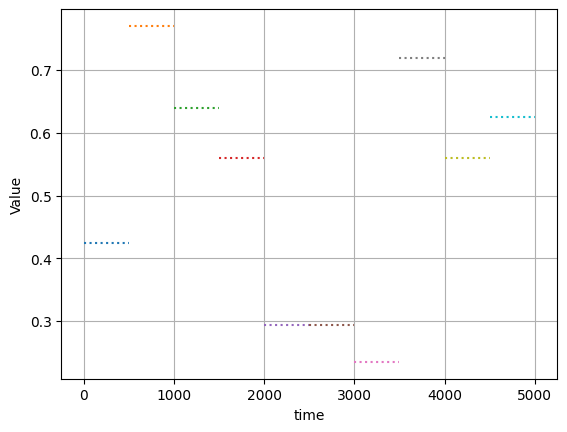

In [15]:
plt.figure("mass flow rate x time")
for i in range(0,10):
    plt.plot(interval[i], np.squeeze(massFlowrate[i]), label='x0(t)')
plt.grid(True)
plt.xlabel('Time')  
plt.ylabel('Value')

plt.figure("Plenum pressure x time")
for i in range(0,10):
    plt.plot(interval[i], np.squeeze(PlenumPressure[i]), label='x0(t)')
plt.grid(True)
plt.xlabel('Time')  
plt.ylabel('Value')

plt.figure("alpha x time")
for i in range(0,10):
    plt.plot(interval[i], np.squeeze(alpha_values[i]), linestyle=':')
plt.grid(True)
plt.xlabel('time') 
plt.ylabel('Value')


plt.show()


In [16]:
RNN_train = np.array(RNN_train)
RNN_test = np.array(RNN_test)
print(RNN_train.shape)
print(RNN_test.shape)

timestep = 4

X = []
yMass = []
yPress = []

x_test = []

for i in range(len(RNN_train[0][0])):
    X.append(RNN_train[:,:,i])
    if i == (len(RNN_train[0][0]) - 1):
        yMass.append(RNN_test[:, :1, 0])
        yPress.append(RNN_test[:, 1:2, 0])
    else:
        yMass.append(RNN_train[:,:1,i+1])
        yPress.append(RNN_train[:,1:2,i+1])
    x_test.append(RNN_test[:,:,i])


X = np.array(X)
print(X.shape)
yMass = np.array(yMass)
yPress = np.array(yPress)
print(yMass.shape)
print(yPress.shape)

x_test = np.array(x_test)


(5, 3, 500)
(5, 3, 500)
(500, 5, 3)
(500, 5, 1)
(500, 5, 1)


In [17]:
opt = 'adam'

modelMass = keras.Sequential()
modelMass.add(layers.Bidirectional(layers.LSTM(50, input_shape=(timestep,3), return_sequences= True)))
modelMass.add(layers.Dropout(0.5))
modelMass.add(layers.Dense(1))

modelMass.compile(optimizer = opt, loss = 'mean_squared_error')

historyM = modelMass.fit(X,yMass,epochs = 1000, verbose = 1)

modelPress = keras.Sequential()
modelPress.add(layers.Bidirectional(layers.LSTM(50, input_shape=(timestep,3), return_sequences= True)))
modelPress.add(layers.Dropout(0.5))
modelPress.add(layers.Dense(1))

modelPress.compile(optimizer = opt, loss = 'mean_squared_error')

historyP = modelPress.fit(X,yPress,epochs = 500, verbose = 1)

Epoch 1/1000


/home/guilhermefreire/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1279   
Epoch 2/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0710 
Epoch 3/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0432 
Epoch 4/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0272 
Epoch 5/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0185 
Epoch 6/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0139 
Epoch 7/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0098 
Epoch 8/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0079 
Epoch 9/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0065 
Epoch 10/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0047 
Epoch 11/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0045 
Epoch 12/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0038 
Epoch 13/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0034 
Epoch 14/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0036 
Epoch 15/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step -

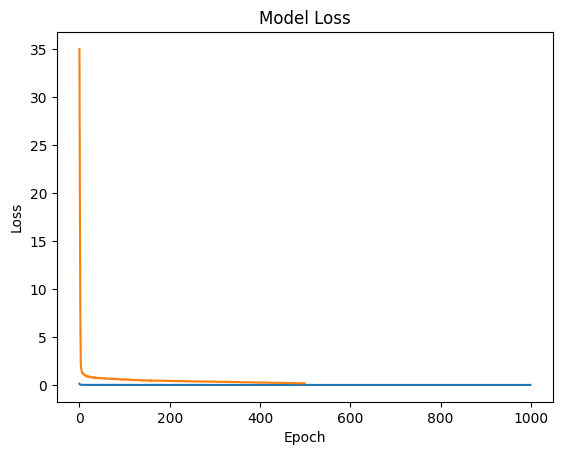

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
(500, 5, 1)


/tmp/ipykernel_27350/761278441.py:29: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[0].legend()
/tmp/ipykernel_27350/761278441.py:39: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[1].legend()


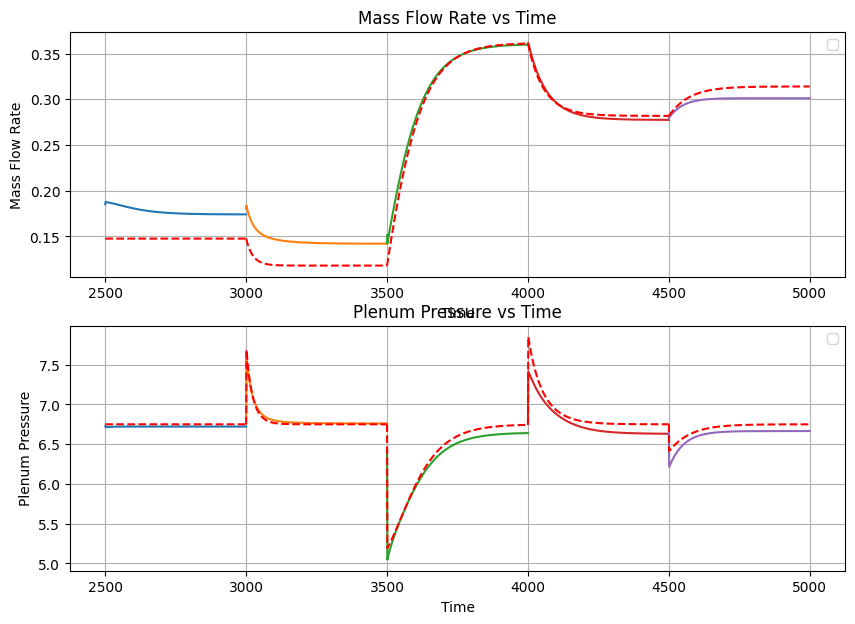

In [18]:
# Plot the training loss
plt.plot(historyM.history['loss'])
plt.plot(historyP.history['loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

# Assuming X_new is the new data for prediction
predictionM = modelMass.predict(x_test)
predictionP = modelPress.predict(x_test)
print(predictionM.shape)

# Extract mass and pressure from prediction
mass = predictionM[:,:,0]
pressure = predictionP[:,:,0]

# Cria uma figura com subplots
fig, axs = plt.subplots(2, 1, figsize=(10, 7))

# Gráfico da mass FlowRate vs. Tempo
for i in range(5, 10):
    axs[0].plot(interval[i], np.squeeze(mass[:,i-5]))
    axs[0].plot(interval[i], np.squeeze(massFlowrate[i]), 'r--')
axs[0].grid(True)
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Mass Flow Rate')
axs[0].set_title('Mass Flow Rate vs Time')
axs[0].legend()

# Gráfico da Pressão do PlenumPressure vs. Tempo
for i in range(5, 10):
    axs[1].plot(interval[i], np.squeeze(pressure[:,i-5]))
    axs[1].plot(interval[i], np.squeeze(PlenumPressure[i]), 'r--')
axs[1].grid(True)
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Plenum Pressure')
axs[1].set_title('Plenum Pressure vs Time')
axs[1].legend()
